# Taxes in the Ramsey model

Interactive version available at https://mybinder.org/v2/gh/marcinbielecki/Advanced_Macroeconomics/master as `Ramsey_taxes.ipynb`

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as opt

### Effects of a pre-announced VAT tax hike

In [2]:
# Calibration follows Ljungqvist and Sargent (2012), p. 395

α = 0.33
δ = 0.2
β = 0.95
g = 0.2
σ = 2    # LS call it γ

In [3]:
# Define production function, MPK and steady state conditions

def f(k):
    return k**α

def df_dk(k):
    return α * k**(α-1)

def RCK_ss(variables, τ_c=0):
    
    (k, c) = variables
    
    y = f(k)
    r = df_dk(k) - δ
    
    EE = β*(1+r) - 1                 # Euler equation
    RC = f(k) + (1-δ)*k - g - c - k  # Resource constraint
    
    return [EE, RC]

In [4]:
# Find old and new steady states

τ_c_0 = 0
τ_c_1 = 0.2

results = opt.fsolve(RCK_ss, (1.5, 0.8), args=(τ_c_0))
print('Initial steady state \t=', results)
k_ss_0 = results[0]
c_ss_0 = results[1]

results = opt.fsolve(RCK_ss, (1.5, 0.8), args=(τ_c_1))
print('Final steady state \t=', results)
k_ss_1 = results[0]
c_ss_1 = results[1]

Initial steady state 	= [1.48995649 0.64264525]
Final steady state 	= [1.48995649 0.64264525]


In [5]:
# Dynamic equations

def Resource_Constraint(k, c, τ_c):
    
    k_n = f(k) + (1-δ)*k - g - c
    
    return k_n

def Interest_Rate(k):
    return df_dk(k) - δ

def Euler_Equation(k, c, τ_c, τ_c_n):
    
    k_n = Resource_Constraint(k, c, τ_c)
    
    if k_n > 0:
        r_n = Interest_Rate(k_n)
        c_n = ( (1+τ_c)/(1+τ_c_n) * β * (1+r_n) )**(1/σ) * c
    else:
        c_n = 0
        
    return c_n

In [6]:
# Forward equations and convergence criterion

def Path(c_0, k_0, Tτ=20, T=50):
    
    T += 1
    
    k_t = np.zeros(T)
    c_t = np.zeros(T)
    τ_c_t = np.zeros(T)
    
    τ_c_t[:Tτ] = τ_c_0
    τ_c_t[Tτ:] = τ_c_1
    
    k_t[0] = k_0
    c_t[0] = c_0
    
    for t in range(T-1):
        k_t[t+1] = Resource_Constraint(k_t[t], c_t[t], τ_c_t[t])
        if k_t[t+1] > 0:
            c_t[t+1] = Euler_Equation(k_t[t], c_t[t], τ_c_t[t], τ_c_t[t+1])
        else:
            k_t[t+1] = 0
            c_t[t+1] = 0
            
    return k_t, c_t

def Path_crit(c_0, k_0, Tτ=20, T=50):
    
    k_t, c_t = Path(c_0, k_0, Tτ, T)
    
    ss_diff = np.sqrt((k_t-k_ss_1)**2 + (c_t-c_ss_1)**2)
    
    return np.min(ss_diff) + ss_diff[-1]

In [7]:
# Find the function minimum, starting from an initial guess
result = opt.minimize(Path_crit, c_ss_0, args=(k_ss_0), method='Powell') # 'Nelder-Mead'
print(result)

c_0 = result.x

   direc: array([[6.33639324e-06]])
     fun: 0.0009482628257852447
 message: 'Optimization terminated successfully.'
    nfev: 88
     nit: 3
  status: 0
 success: True
       x: array(0.64343524)


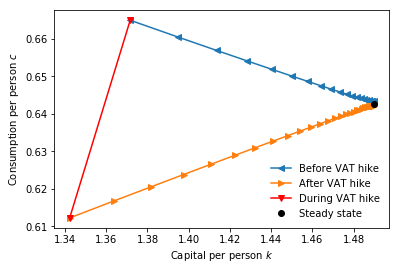

In [8]:
# Plot the phase diagram

k_t, c_t = Path(c_0, k_ss_0)

plt.plot(k_t[:20], c_t[:20], '<-', label='Before VAT hike')
plt.plot(k_t[20:], c_t[20:], '>-', label='After VAT hike')
plt.plot(k_t[19:21], c_t[19:21], 'rv-', label='During VAT hike')
plt.plot(k_ss_1, c_ss_1, 'ko', label='Steady state')
plt.legend(frameon=False)
plt.xlabel('Capital per person $k$')
plt.ylabel('Consumption per person $c$')
plt.show()

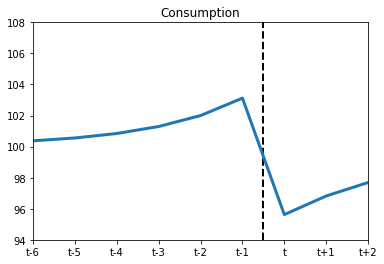

In [9]:
# Convert to montly frequency and display as time series

c_t_m = np.mean(np.array(c_t[:-1]).reshape(-1, 2), axis=1)

# plt.subplots(figsize=(20, 15))

plt.plot(100*c_t_m/c_ss_0, lw=3)
plt.vlines(9.5, 94, 108, lw=2, linestyle='dashed')
plt.ylim(94, 108)
plt.xlim(4, 12)
plt.xticks(np.linspace(4, 12, 9), ['t-6', 't-5', 't-4', 't-3', 't-2', 't-1', 't', 't+1', 't+2'])
plt.title('Consumption')
plt.show()

Compare the above outcome to the real-world behavior of consumption in Germany and Japan around the VAT tax hikes

![Effects of VAT tax hikes](img/RCK/figure-one.jpg)

Source: [Danninger (2014) What Japan’s economy needs now](https://www.weforum.org/agenda/2014/08/japan-consumption-tax-structural-reform-abenomics/)

### Consumption vs labor tax when households choose labor input

In [10]:
# Parameters

A = 1
α = 1/3
δ = 0.1
ρ = 1/30
β = 1/(1+ρ)
print(β)

φ = 1.7777777777

0.9677419354838709


In [11]:
# Functions that are not affected by taxes nor the utility function

def k_h(A, α, δ, ρ):
    return (α*A/(δ+ρ))**(1/(1-α))

def y_h(A, α, δ, ρ):
    return k_h(A, α, δ, ρ)**α

def w(A, α, δ, ρ):
    return (1-α)*y_h(A, α, δ, ρ)

def c_h(A, α, δ, ρ):
    return y_h(A, α, δ, ρ) - δ*k_h(A, α, δ, ρ)

In [12]:
# Functions that are affected by taxes and utility function

def h(A, α, δ, ρ, φ, τ_w=0, τ_c=0):
    try:
        return 1/( 1 + φ * (1+τ_c)/(1-τ_w)/w(A, α, δ, ρ) * c_h(A, α, δ, ρ) )
    except:
        return 0
    
h = np.vectorize(h)

In [13]:
h(A, α, δ, ρ, φ)

array(0.33333333)

In [14]:
ττ = np.linspace(0, 1, 1+1000)

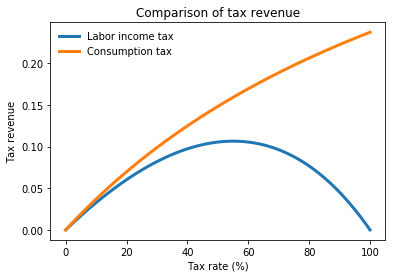

In [15]:
plt.plot(ττ*100, ττ*w(A, α, δ, ρ)*h(A, α, δ, ρ, φ, ττ, 0), lw=3, label='Labor income tax')
plt.plot(ττ*100, ττ*c_h(A, α, δ, ρ)*h(A, α, δ, ρ, φ, 0, ττ), lw=3, label='Consumption tax')

plt.title('Comparison of tax revenue')
plt.xlabel('Tax rate (%)')
plt.ylabel('Tax revenue')
plt.legend(frameon=False)

plt.show()

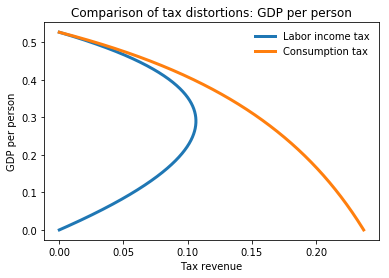

In [16]:
plt.plot(ττ*w(A, α, δ, ρ)*h(A, α, δ, ρ, φ, ττ, 0), 
         y_h(A, α, δ, ρ)*h(A, α, δ, ρ, φ, ττ, 0), lw=3, label='Labor income tax')

plt.plot(ττ*c_h(A, α, δ, ρ)*h(A, α, δ, ρ, φ, 0, ττ), 
         y_h(A, α, δ, ρ)*h(A, α, δ, ρ, φ, ττ, 0), lw=3, label='Consumption tax')

plt.title('Comparison of tax distortions: GDP per person')
plt.xlabel('Tax revenue')
plt.ylabel('GDP per person')
plt.legend(frameon=False)

plt.show()

Can the model explain the differences between the average hours worked in the USA vs Germany & France based on the differences in the average labor income tax rate?

In [17]:
# Data

USA_h = 1790 / 8766
USA_GDP_ph = 59
USA_GDP_pc = 102500
USA_τ_w = 0.255       # Average labor income tax rate in the US

FR_DE_h = 1465 / 8766
FR_DE_GDP_ph = 56
FR_DE_GDP_pc = 82200
FR_DE_τ_w = 0.4375    # Average labor income tax rate in France & Germany

In [18]:
# Model outcomes

USA_h_model = h(1, α, δ, ρ, φ, USA_τ_w, 0)
FR_DE_h_model = h(FR_DE_GDP_ph/USA_GDP_ph, α, δ, ρ, φ, FR_DE_τ_w, 0)

print('Ratio of hours worked: USA vs FR & DE')
print('Model \t', USA_h_model/FR_DE_h_model)
print('Data \t', USA_h/FR_DE_h)

USA_y_model = h(1, α, δ, ρ, φ, USA_τ_w, 0)*y_h(1, α, δ, ρ)
FR_DE_y_model = h(FR_DE_GDP_ph/USA_GDP_ph, α, δ, ρ, φ, FR_DE_τ_w, 0)*y_h(FR_DE_GDP_ph/USA_GDP_ph, α, δ, ρ)

print('\nRatio of GDP per person: USA vs FR & DE')
print('Model \t', USA_y_model/FR_DE_y_model)
print('Data \t', USA_GDP_pc/FR_DE_GDP_pc)

Ratio of hours worked: USA vs FR & DE
Model 	 1.2527451040896995
Data 	 1.2218430034129693

Ratio of GDP per person: USA vs FR & DE
Model 	 1.2858630193474705
Data 	 1.2469586374695865
